In [1]:
from os.path import join as pathjoin
from data_processing import *
from interpretation import *
from models import *
from training import *

In [2]:
DATA_DIR = '/home/mlepekhin/data/min_gpt_bpe'
MODELS_DIR = '/home/mlepekhin/models'
MODEL_ID = 'allennlp_rubert_from_topic_generated2'
CHECKPOINTS_DIR = pathjoin(MODELS_DIR, MODEL_ID, 'checkpoints')
BEST_MODEL = pathjoin(CHECKPOINTS_DIR, 'best.th')

In [3]:
transformer_model = 'DeepPavlov/rubert-base-cased'
MAX_TOKENS = 512

### Loading of the pretrained model

In [4]:
vocab = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID, 'vocab'))
model = build_transformer_model(vocab, transformer_model)

Building the model


In [5]:
id_to_label = vocab.get_index_to_token_vocabulary('labels')
print(id_to_label)
print(id_to_label.values())

{0: 'A4', 1: 'A7', 2: 'A14', 3: 'A17', 4: 'A9', 5: 'A11', 6: 'A8', 7: 'A12', 8: 'A1', 9: 'A16', 10: 'discussion', 11: 'info'}
dict_values(['A4', 'A7', 'A14', 'A17', 'A9', 'A11', 'A8', 'A12', 'A1', 'A16', 'discussion', 'info'])


In [6]:
if torch.cuda.is_available():
    cuda_device = 1
else:
    cuda_device = -1
print(cuda_device)
model.load_state_dict(torch.load(BEST_MODEL, map_location=f'cuda:{cuda_device}'))

1


<All keys matched successfully>

### Data loading

In [15]:
ru_test_df = pd.read_csv('/home/mlepekhin/data/ru_test_half.csv')
ru_test_df.head()

,Unnamed: 0,Unnamed: 0.1,target,text
0,412,297,discussion,Мы живём в мрачные экономические времена товар...
1,74,608,info,ОАО « Нижнекамскнефтехим » ( НКНХ ) не отказыв...
2,947,598,info,« Локомотив-Белогорье » заявил в состав Игоря ...
3,500,171,discussion,Александр Дугин ИМПЕРИЯ НАШЕГО ЗАВТРА В нашем ...
4,604,287,discussion,"Итак , я детский онколог и исследователь ствол..."


In [9]:
true_classes = ru_test_df.target.values
sentences = ru_test_df.text.values

### Preliminary analysis

In [10]:
dataset_reader = build_transformer_dataset_reader(transformer_model, MAX_TOKENS)
predictor = TextClassifierPredictor(model, dataset_reader=dataset_reader)
predicted_classes = np.array(predict_classes(sentences, predictor, vocab))

In [11]:
print(type(predicted_classes == 'A1'))

<class 'numpy.ndarray'>


In [12]:
print(len(np.unique(true_classes)))

2


In [13]:
calc_classifier_metrics(predicted_classes, true_classes)

accuracy 0.9523809523809523


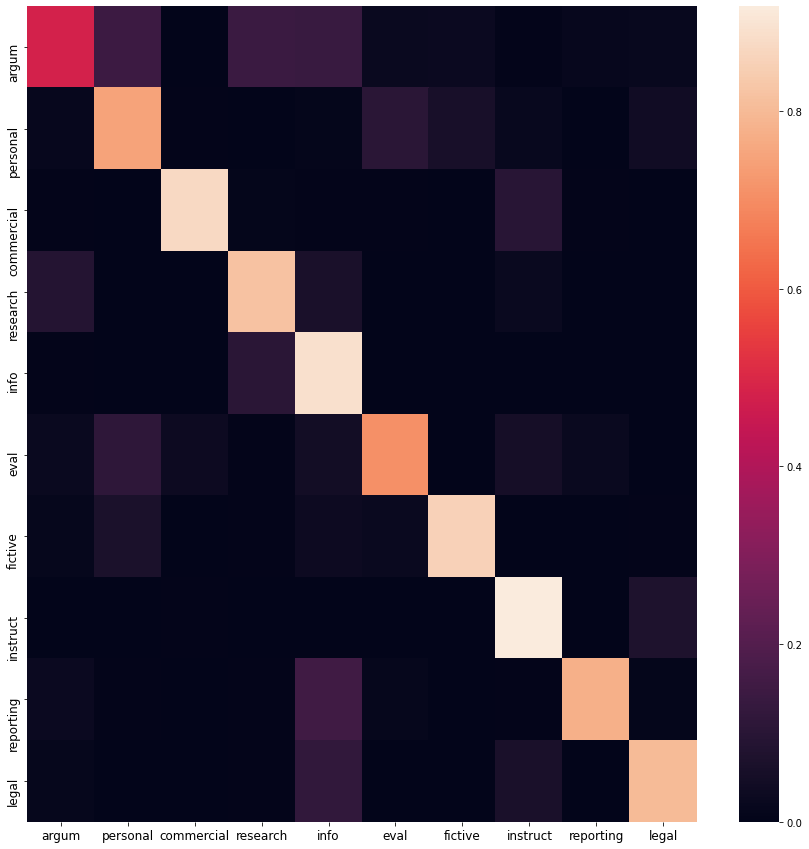

In [16]:
plot_confusion_matrix(predicted_classes, true_classes)

### Topic analysis

In [17]:
def analyze_topics(topic_df, predicted_classes):
    count_by_topic, correct_count_by_topic = dict(), dict()
    
    for item_id, predicted_class in enumerate(predicted_classes):
        topic = topic_df.topic.values[item_id]
        true_class = topic_df.target.values[item_id]
        if topic not in count_by_topic:
            correct_count_by_topic[topic] = count_by_topic[topic] = 0
        count_by_topic[topic] += 1
        correct_count_by_topic[topic] += (predicted_class == true_class)
        
    for topic, count in count_by_topic.items():
        print("topic:", topic)
        print("accuracy:", correct_count_by_topic[topic] / count)

In [18]:
analyze_topics(ru_test_df, predicted_classes)

topic: music
accuracy: 0.776
topic: education
accuracy: 0.776
topic: politics
accuracy: 0.72
topic: sport
accuracy: 0.752
topic: business
accuracy: 0.764
topic: literature
accuracy: 0.748
topic: crime
accuracy: 0.738
topic: travel
accuracy: 0.766
topic: games
accuracy: 0.75
topic: arhitecture
accuracy: 0.774
